# **Clustering Models Assignment**



Data Collection:

* Cal Fire Statistics: Load data from Cal Fire statistics (e.g., PDF tables might need manual extraction or conversion to CSV).

* NASA MODIS Fire Detections: Use the NASA API to fetch fire detection data.

* USGS Streamflow Gaging Systems: Fetch data from USGS for streamflow and water levels.

* FEMA National Risk Index: Download and load data from FEMA's National Risk Index.

* NOAA Integrated Surface Data: Use NOAA's API to fetch weather data.

#### **For walkthrough and example code on how to load API, see the Logistic Regression notebook.**

## **Data Loading**

Load the relevant dataset you're looking at (FEMA, USDA, Cal Fire, etc.). If the data are not in CSV, or you are loading through an API, adjust the code accordingly.

In [14]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from pathlib import Path

# =========================
# Load Datasets
# =========================

file_path_ca = Path('../Data/NRI_Table_Counties_California.csv')
file_path_tx = Path('../Data/NRI_Table_Counties_Texas.csv')
file_path_la = Path('../Data/NRI_Table_Counties_Louisiana.csv')
file_path_al = Path('../Data/NRI_Table_Counties_Alabama.csv')
file_path_fl = Path('../Data/NRI_Table_Counties_Florida.csv')
file_path_ms = Path('../Data/NRI_Table_Counties_Mississippi.csv')
file_path_us = Path('../Data/uscounties.csv')

df_ca = pd.read_csv(file_path_ca)
df_tx = pd.read_csv(file_path_tx)
df_la = pd.read_csv(file_path_la)
df_al = pd.read_csv(file_path_al)
df_fl = pd.read_csv(file_path_fl)
df_us = pd.read_csv(file_path_us)

# =========================
# Combine California and Texas County Data
# =========================
states_combined_df = pd.concat([df_ca, df_tx, df_la, df_al, df_fl])

# =========================
# Select Relevant Columns
# =========================

# Select relevant columns
nri_df = states_combined_df[['COUNTY', 'POPULATION', 'CFLD_RISKS', 'WFIR_RISKS']]

# =========================
# Get Latitude and Longitude Information
# =========================
filtered_us = df_us[df_us['state_id'].isin(['CA', 'TX', 'LA', 'AL', 'FL', 'MS'])]
lat_lon_df = filtered_us[['county', 'lat', 'lng']]

# =========================
# Merge NRI data with Location Data
# =========================
merged_df = pd.merge(nri_df, lat_lon_df, left_on='COUNTY', right_on='county')
merged_df = merged_df.fillna(0)
merged_df = merged_df.drop('county', axis=1)

# =========================
# Standardize Risk and Population Data
# =========================
scaler = StandardScaler()

X_scaled_fire = scaler.fit_transform(merged_df[['WFIR_RISKS', 'POPULATION']])
X_scaled_flood = scaler.fit_transform(merged_df[['CFLD_RISKS', 'POPULATION']])

# =========================
# Final Data Check
# =========================
merged_df.tail(10)

,COUNTY,POPULATION,CFLD_RISKS,WFIR_RISKS,lat,lng
713,Union,16088,0.000000,84.123449,32.8318,-92.3748
714,Union,16088,0.000000,84.123449,30.0439,-82.3714
715,Volusia,551829,87.323944,98.218263,29.0584,-81.1819
716,Wakulla,33756,54.527163,91.473115,30.1673,-84.4007
717,Walton,75211,41.046278,81.482660,30.6436,-86.1697
718,Washington,25288,20.321932,75.182946,30.8533,-90.0405
719,Washington,25288,20.321932,75.182946,33.2839,-90.9474
720,Washington,25288,20.321932,75.182946,30.2145,-96.4034
721,Washington,25288,20.321932,75.182946,30.6106,-85.6653
722,Washington,25288,20.321932,75.182946,31.4076,-88.2079


# K-Means Clustering

K-Means clustering is an unsupervised machine learning algorithm used to group data points into k distinct clusters based on their similarity. It works by initializing k cluster centers, assigning data points to the nearest center, and iteratively adjusting the centers until convergence. The choice of k (the number of clusters) significantly impacts the quality of clustering. To determine the optimal k, we recommend using the Elbow Method, which analyzes the inertia (sum of squared distances) to find a point where adding more clusters no longer significantly improves the fit. Additionally, the Silhouette Score can be used to evaluate how well-separated the clusters are, with higher scores indicating better-defined clusters. **ASSIGNMENT: you should (1) load real geospatial risk datasets (FEMA, USDA, etc.), (2) test different k values using the methods above, (3) refine clustering by adding more relevant features (e.g., elevation, land cover), and (4) interpret the clusters to assess their effectiveness in identifying high-risk fire and flood areas**

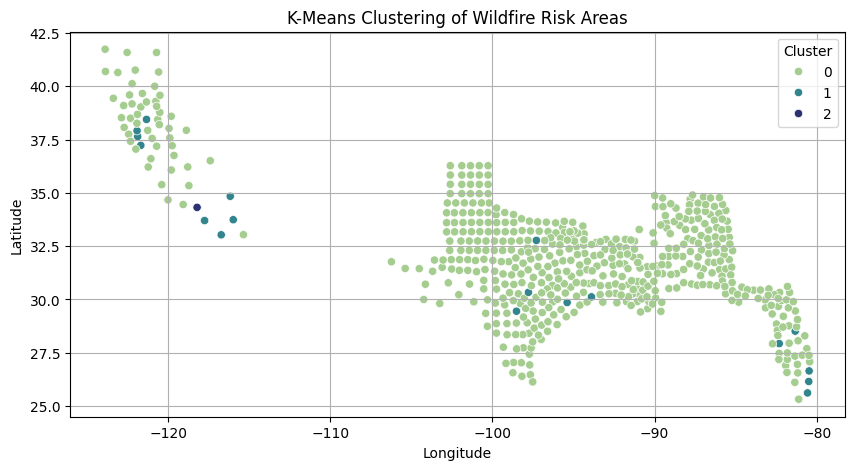

Silhouette Score for Wildfire Risk Clustering: 0.69


In [15]:
# =========================
# K-Means Clustering - Wildfire Risk
# =========================
kmeans_fire = KMeans(n_clusters=3, random_state=42)
merged_df['kmeans_fire_cluster'] = kmeans_fire.fit_predict(X_scaled_fire)

# Plotting wildfire clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=merged_df,
    x='lng',
    y='lat',
    hue='kmeans_fire_cluster',
    palette='crest'
)
plt.title("K-Means Clustering of Wildfire Risk Areas")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

# =========================
# Silhouette Score Evaluation (Wildfire)
# =========================
silhouette_fire = silhouette_score(X_scaled_fire, merged_df['kmeans_fire_cluster'])
print(f"Silhouette Score for Wildfire Risk Clustering: {silhouette_fire:.2f}")


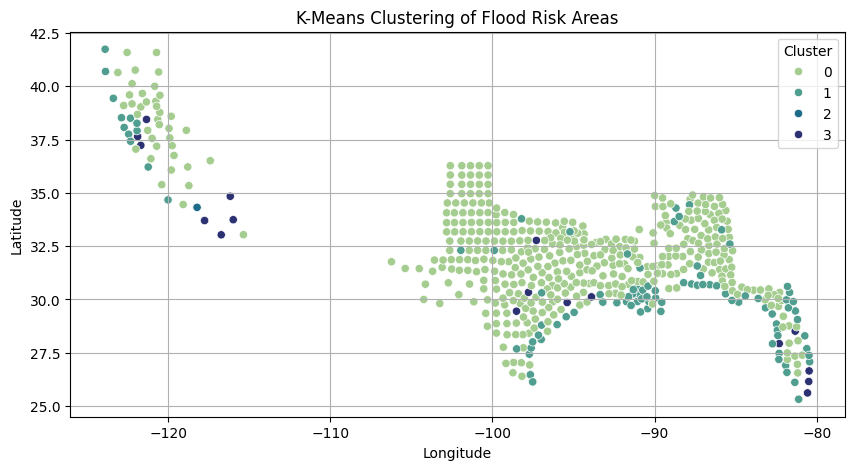

Silhouette Score for Flood Risk Clustering: 0.79


In [16]:
# =========================
# K-Means Clustering - Flood Risk
# =========================
kmeans_flood = KMeans(n_clusters=4, random_state=42)
merged_df['kmeans_flood_cluster'] = kmeans_flood.fit_predict(X_scaled_flood)

# Plotting flood clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=merged_df,
    x='lng',
    y='lat',
    hue='kmeans_flood_cluster',
    palette='crest'
)
plt.title("K-Means Clustering of Flood Risk Areas")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

# =========================
# Silhouette Score Evaluation (Flood)
# =========================
silhouette_flood = silhouette_score(X_scaled_flood, merged_df['kmeans_flood_cluster'])
print(f"Silhouette Score for Flood Risk Clustering: {silhouette_flood:.2f}")

In [17]:
# =========================
# Load Datasets
# =========================
rubicon_path = Path('../Data/DeployableGreyshirts_Qualifications.xlsx - US Deployable Greyshirts.csv')
zip_path = Path('../Data/uszips.csv')

rubicon_df = pd.read_csv(rubicon_path)
zip_df = pd.read_csv(zip_path)

# =========================
# Filter Zip Codes for Included States
# =========================
all_states_zipcodes = zip_df[zip_df['state_id'].isin(['CA', 'TX', 'LA', 'AL', 'FL', 'MS'])]

# =========================
# Clean Zip Codes in rubicon_df
# =========================
# Coerce 'Zip/Postal Code ID' to numeric (turn invalid entries into NaN), then drop missing
rubicon_df['Zip/Postal Code ID'] = pd.to_numeric(rubicon_df['Zip/Postal Code ID'], errors='coerce')
rubicon_df = rubicon_df.dropna(subset=['Zip/Postal Code ID'])
rubicon_df['Zip/Postal Code ID'] = rubicon_df['Zip/Postal Code ID'].astype(int)

# =========================
# Merge Datasets on Zip Code
# =========================
zipcodes_merged = pd.merge(
    all_states_zipcodes,
    rubicon_df,
    left_on='zip',
    right_on='Zip/Postal Code ID'
)

# =========================
# Check Column Names
# =========================
zipcodes_merged.columns

/var/folders/ns/fw1b4jd51k1720pskv5tw_p80000gn/T/ipykernel_55837/2242472709.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  rubicon_df = pd.read_csv(rubicon_path)


Index(['zip', 'lat', 'lng', 'city', 'state_id', 'state_name', 'zcta',
       'parent_zcta', 'population', 'density', 'county_fips', 'county_name',
       'county_weights', 'county_names_all', 'county_fips_all', 'imprecise',
       'military', 'timezone', '(Do Not Modify) Contact ID',
       '(Do Not Modify) Row Checksum', '(Do Not Modify) Modified On',
       'User ID', 'Created On', 'Date Deployable', 'Zip/Postal Code ID',
       'City', 'Metro', 'State/Province', 'Branch', '# of Deployments',
       'HEO-1 Q?', 'HEO-2 Q?', 'HEO-2(CTL) Q?', 'HEO-2(EX) Q?', 'HEO-3 Q?',
       'HESI Q?', 'HIZ Trained C?', 'C2 Q?', 'CI Q?', 'CI-2 Q?', 'Sawyer 1 Q?',
       'Sawyer 2 Q?', 'Advanced Sawyer 1 Q?', 'RC HEO C?', 'RC Saw C?',
       'RC TFL C?', 'R/A Q?', 'SS Qual?', 'Core Ops Q?', 'Roof Tarping C?',
       'STL Trained C?'],
      dtype='object')

In [18]:
# =========================
# Keep Only Necessary Columns
# =========================
zipcodes_merged = zipcodes_merged[['zip', 'lat', 'lng', 'city', 'state_id', 'population', 'county_name',
                                   '# of Deployments']]
zipcodes_merged.head()

,zip,lat,lng,city,state_id,population,county_name,# of Deployments
0,32003,30.09813,-81.71255,Fleming Island,FL,29351.0,Clay,2
1,32003,30.09813,-81.71255,Fleming Island,FL,29351.0,Clay,0
2,32003,30.09813,-81.71255,Fleming Island,FL,29351.0,Clay,2
3,32003,30.09813,-81.71255,Fleming Island,FL,29351.0,Clay,0
4,32003,30.09813,-81.71255,Fleming Island,FL,29351.0,Clay,0


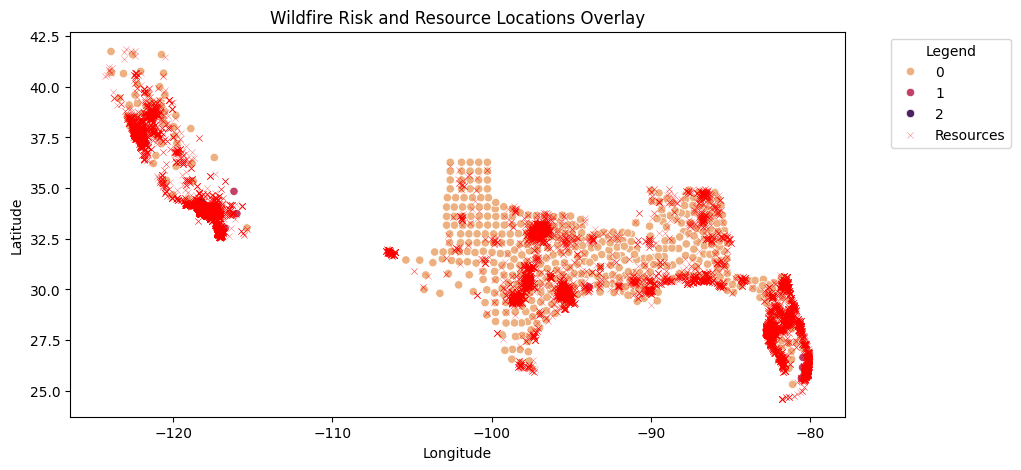

In [19]:
# =========================
# Plot Wildfire Risk Clusters
# =========================
plt.figure(figsize=(10, 5))

# Wildfire clusters first
sns.scatterplot(
    data=merged_df,
    x='lng',
    y='lat',
    hue='kmeans_fire_cluster',
    palette='flare',
    legend='full'
)

# =========================
# Overlay Resource Locations
# =========================
sns.scatterplot(
    data=zipcodes_merged,
    x='lng',
    y='lat',
    alpha = 0.5,
    color='red',
    marker='x',
    s=20,
    label='Resources'
)

plt.title("Wildfire Risk and Resource Locations Overlay")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

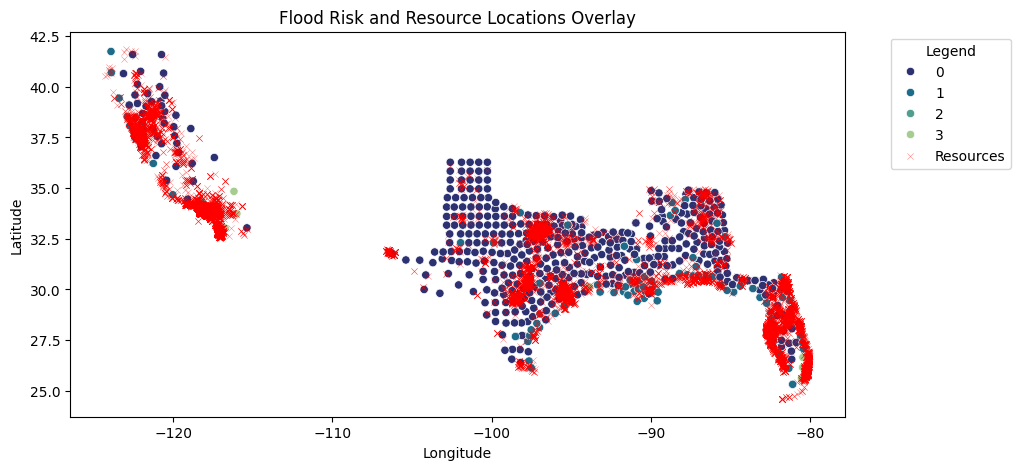

In [20]:
# =========================
# Plot Flood Risk Clusters
# =========================
plt.figure(figsize=(10, 5))

# Flood risk clusters first
sns.scatterplot(
    data=merged_df,
    x='lng',
    y='lat',
    hue='kmeans_flood_cluster',
    palette='crest_r',
    legend='full'
)

# =========================
# Overlay Resource Locations
# =========================
sns.scatterplot(
    data=zipcodes_merged,
    x='lng',
    y='lat',
    alpha = 0.5,
    color='red',
    marker='x',
    s=20,
    label='Resources'
)

# =========================
# Plot Settings
# =========================
plt.title("Flood Risk and Resource Locations Overlay")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Density-Based Clustering (DBSCAN)

---



DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is an unsupervised clustering algorithm that groups data points based on density, making it useful for identifying clusters of varying shapes and sizes while detecting outliers. Unlike K-Means, DBSCAN does not require specifying the number of clusters (k) beforehand. Instead, it relies on two parameters: eps (maximum distance for points to be considered neighbors) and min_samples (minimum points needed to form a dense region). If points have enough close neighbors, they form a cluster; otherwise, they are classified as noise (-1). To optimize DBSCAN, the team should experiment with different values of eps and min_samples, using k-distance plots or Silhouette Score evaluations to find the best settings. **ASSIGNMENT: you should (1) analyze DBSCAN's effectiveness in clustering geospatial fire and flood risk data, (2) adjust parameters to handle varying data densities, and (3) compare DBSCAN results to K-Means and Hierarchical Clustering for better interpretability of risk-prone areas.**



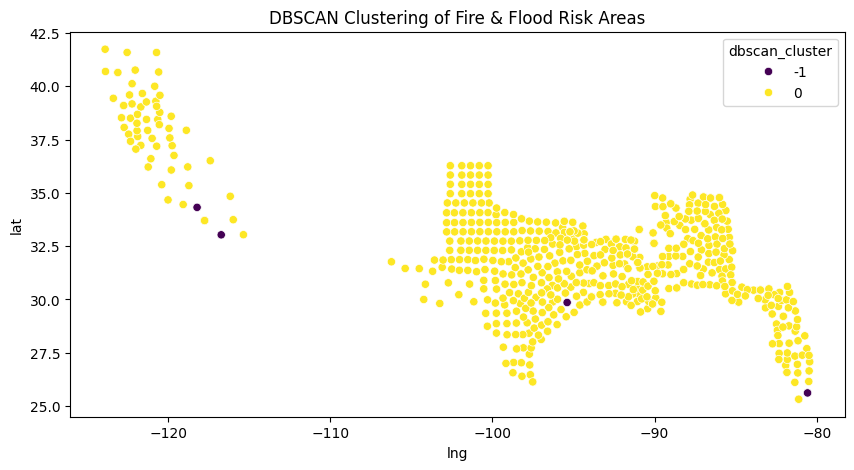

In [21]:

# DBSCAN Clustering
dbscan = DBSCAN(eps=1, min_samples=5)
merged_df["dbscan_cluster"] = dbscan.fit_predict(X_scaled_flood)
# Used for clusters of similar density. Read up on the Sklearn documentation and research the technique.

# DBSCAN Visualization
plt.figure(figsize=(10, 5))
sns.scatterplot(data=merged_df, x="lng", y="lat", hue="dbscan_cluster", palette="viridis", legend="full")
plt.title("DBSCAN Clustering of Fire & Flood Risk Areas")
plt.show()


## Hierarchical Clustering

Hierarchical clustering is a method that builds a tree-like structure (dendrogram) to group data based on similarity, without requiring a predefined number of clusters. It works by either agglomerative merging (starting with individual points and combining them) or divisive splitting (starting with all points and recursively splitting them). The Ward method, used in our implementation, minimizes cluster variance to form well-separated groups. The number of clusters can be chosen by cutting the dendrogram at an appropriate height, where large vertical gaps indicate natural divisions. **ASSIGNMENT: you should (1) analyze dendrogram structures to decide the most meaningful number of clusters, (2) compare results with K-Means and DBSCAN to determine which method captures fire and flood risk patterns best, and (3) experiment with different linkage criteria (e.g., complete, single, average) to refine cluster formation.** Hierarchical clustering is particularly useful for understanding hierarchical relationships within risk zones and ensuring robust classification of high-risk areas.

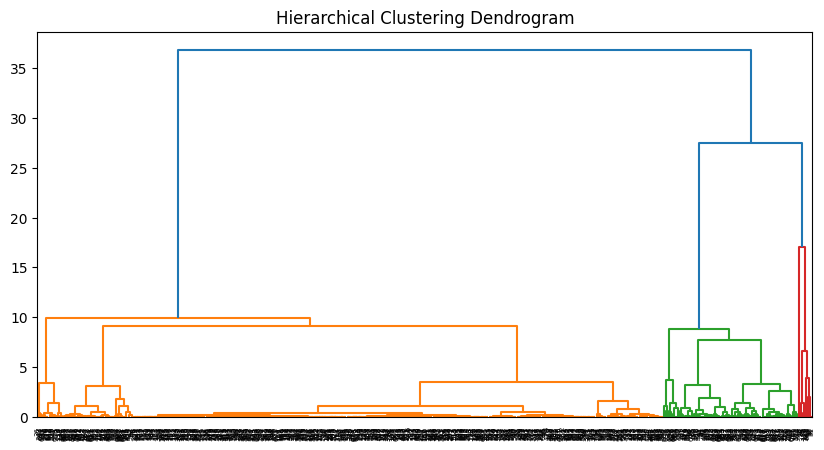

In [22]:

# Hierarchical Clustering
dendro = linkage(X_scaled_flood, method='ward')
# hierarchial based clustering, the tree helps visualize data points that have longest links before merging.


# HIERARCHAIL Clustering Dendrogram
plt.figure(figsize=(10, 5))
dendrogram(dendro)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()
